In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import model_b2 as model
import emcee
from multiprocess import Pool
from scipy import stats
import scienceplots
plt.style.use('science')

In [2]:
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
flat_chain = np.load('model_b2.npy')

In [4]:
ns, nd = flat_chain.shape
nskip = ns // 1000

In [5]:
ns / nskip

1309.5

In [6]:
output_dir = 'output_b2/'
model_specifier = 'R_matrix_Bayesian_capture_'

In [7]:
%%time
ext = model.azr.extrapolate(flat_chain[0], use_gsl=True, ext_capture_file=output_dir + 'intEC.extrap')

CPU times: user 2.58 ms, sys: 10.2 ms, total: 12.7 ms
Wall time: 351 ms


In [8]:
with Pool(4) as pool:
    exts = pool.map(lambda theta: model.azr.extrapolate(theta, use_gsl=True,
                                                        ext_capture_file=output_dir + 'intEC.extrap'),
                    flat_chain[::nskip])

In [9]:
from scipy.optimize import curve_fit

In [10]:
def fit_br0(ext):
    energies, bran_rats = ext[0][:, 0], ext[1][:, 3] / ext[0][:, 3]
    pars, cov = curve_fit(lambda z, m, b: m*z + b, energies, bran_rats)
    return pars


ne = int((0.1 - 0.001) / 0.001)

def fit_S0(extrap):
    x = extrap[-1][:ne, 0]
    y = extrap[-1][:ne, 4]
    pars, cov = curve_fit(lambda z, m, b: m*z + b, x, y)
    return pars

In [11]:
br0_pars = np.array([fit_br0(ext) for ext in exts])

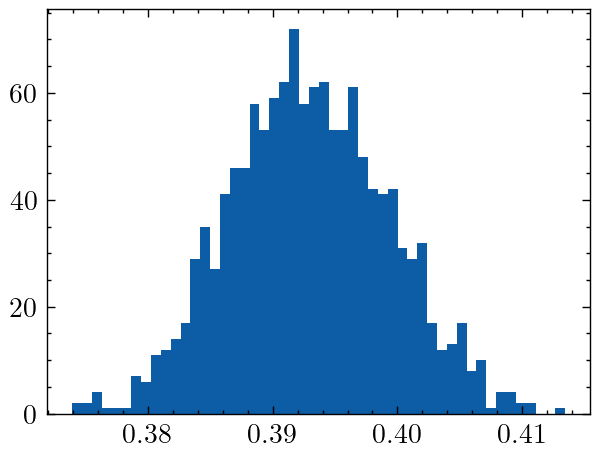

In [12]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.hist(br0_pars[:, 1], bins=50);

In [13]:
np.savetxt(output_dir + model_specifier + 'branching_ratios.txt', br0_pars[:, 1],
           header='Branching Ratio')

In [14]:
low, med, high = np.quantile(br0_pars[:, 1], [0.16, 0.5, 0.84])
print('$%.3f^{+%.3f}_{-%.3f}$' % (med, high-med, med-low))

$0.393^{+0.007}_{-0.006}$


In [15]:
s0_pars = np.array([fit_S0(ext) for ext in exts])

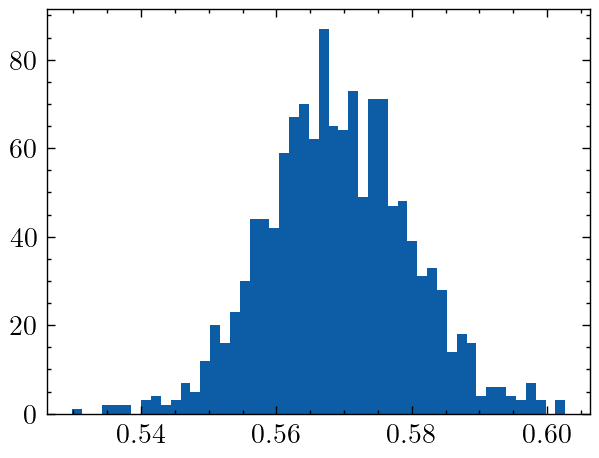

In [16]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.hist(s0_pars[:, 1]*1000, bins=50);

In [17]:
np.savetxt(output_dir + model_specifier + 'S0.txt', s0_pars[:, 1]*1000, header='S(0) in keV b')

In [18]:
low, med, high = np.quantile(s0_pars[:, 1]*1000, [0.16, 0.5, 0.84])
print('%.3f^{+%.3f}_{-%.3f}' % (med, high-med, med-low))

0.569^{+0.011}_{-0.010}


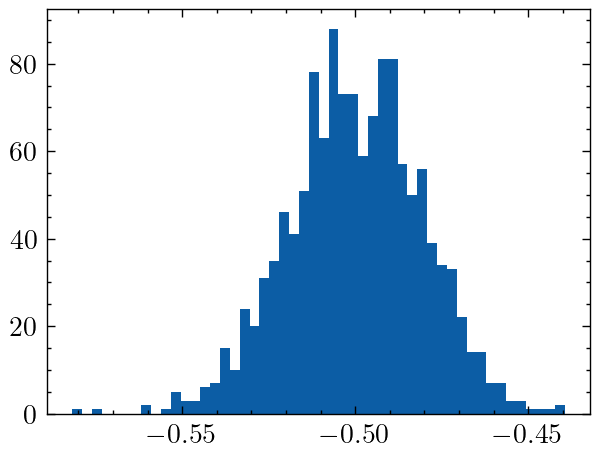

In [19]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.hist(s0_pars[:, 0]/s0_pars[:, 1], bins=50);

In [20]:
np.savetxt(output_dir + model_specifier + 'Sp0S0.txt', s0_pars[:, 0]/s0_pars[:, 1],
           header='S\'(0)/S(0) in inverse MeV')

In [21]:
low, med, high = np.quantile(s0_pars[:, 0]/s0_pars[:, 1], [0.16, 0.5, 0.84])
print('%.2f^{+%.2f}_{-%.2f}' % (med, high-med, med-low))

-0.50^{+0.02}_{-0.02}


In [22]:
def calc_SE(ext):
    return ext[-1][ne:, 4]

In [23]:
ses = np.array([calc_SE(ext) for ext in exts])

In [24]:
np.quantile(ses, [0.025, 0.16, 0.5, 0.84, 0.975], axis=0)

array([[0.00052446, 0.00052166, 0.00051881, ..., 0.00041533, 0.00041649,
        0.00041766],
       [0.00053308, 0.00053022, 0.00052732, ..., 0.00042657, 0.0004278 ,
        0.00042904],
       [0.00054207, 0.00053915, 0.00053619, ..., 0.00043781, 0.00043912,
        0.00044041],
       [0.00055202, 0.00054892, 0.00054584, ..., 0.00044995, 0.00045128,
        0.00045263],
       [0.00056216, 0.000559  , 0.00055576, ..., 0.00046066, 0.00046213,
        0.00046361]])

In [25]:
np.savetxt(output_dir + model_specifier + 'SE.txt',
           np.vstack((exts[0][-1][ne:, 0], np.quantile(ses, [0.025, 0.16, 0.5, 0.84, 0.975], axis=0))).T,
           header='S(E)\nE  2.5%  16%  50%  84%  97.5%')